In [1]:
import numpy as np 
from sklearn.cluster import KMeans
from xmlrpc.client import MAXINT
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
png_image = Image.open("./Test1.png")

In [3]:
image = np.asarray(png_image) # Numpy array of the image
height = image.shape[0]
width = image.shape[1]

image = np.delete(image, 3, 2) # Deleteing the alpha value column

image = image.reshape(height*width, 3)/255

## Defining the Class for a FoodSource

In [4]:
class FoodSource:
    clusters = None
    trials = None
    preds = None
    fitnessValue = None

    def fitness(self, imageData):
        value = 0
        for index, pixel in enumerate(imageData):
            cluster = self.preds[index]
            value = value + np.sum((self.clusters[cluster] - pixel)**2)

        return 1/(1 + value)

    def reconstruct(self):
        newImage = np.asarray([self.clusters[i] for i in self.preds])
        newImage = newImage.reshape(height, width, 3)

        return newImage
    
    def predict(self, imageData):
        self.preds = []
        for index in range(imageData.shape[0]):
            pixel = imageData[index]
            predPixel = []
            
            for cluster in self.clusters:
                value = np.sum((cluster - pixel)**2)
                predPixel.append(value)
                
            indCluster = np.argmin(predPixel)
            self.preds.append(indCluster)
        
        return self.preds
    
    def error(self):
        return (1 / self.fitnessValue) - 1

## Parameters of the Algorithm

In [5]:
nPop = 20
nfoodSources = nPop // 2
nClusters = 8
pKmeans = 0.3
limit = 5

maxEpochs = 20

## Randomly initialising food sources

In [6]:
# Definfing all the Food Sources
foodSources = []
for index in range(nfoodSources):
    foodSource = FoodSource()
    foodSource.clusters = image[np.random.randint(1, height*width, nClusters)]
    foodSource.trials = 0
    
    foodSources.append(foodSource)

# Defining GlobalBest
globalBest = FoodSource()
globalBest.fitnessValue = -MAXINT

## Running the Artifical Bee Colony for `maxEpochs`

In [7]:
indices = set(range(len(foodSources)))

for epoch in range(maxEpochs):
    
    # Employeed Bee Phase
    for index, source in enumerate(foodSources):
        
        model = None
        option = None
        if pKmeans < np.random.uniform(0, 1):
            model = KMeans(n_clusters = nClusters, n_init = 1, init = source.clusters, max_iter = 5)
            option = 0
        elif source.preds is None:
            model = KMeans(n_clusters = nClusters, n_init = 1, init = source.clusters, max_iter = 5)
            option = 1
            
        if option is not None:
            model.fit(image)

            source.preds = model.predict(image)
            source.clusters = model.cluster_centers_
            source.fitnessValue = source.fitness(image)

        # Altering the current source to its neighbour
        newSource = FoodSource()
        newSource.clusters = source.clusters.copy()
        newSource.trials = 0

        phi = np.random.random()
        j = np.random.randint(0, nClusters) # Random dimension
        K = foodSources[np.random.choice(list(indices - {index}))] # Random source

        newSource.clusters[j] = source.clusters[j] + phi*(source.clusters[j] - K.clusters[j])
        
        newModel = KMeans(n_clusters = nClusters, n_init = 1, init = newSource.clusters, max_iter = 1)
        newModel.fit(image)
        
        newSource.preds = newModel.predict(image)
        newSource.clusters = newModel.cluster_centers_
        newSource.fitnessValue = newSource.fitness(image)
        
        if newSource.fitnessValue > source.fitnessValue:
            foodSources[index] = newSource
        else:
            foodSources[index].trials += 1
            
        if foodSources[index].fitnessValue > globalBest.fitnessValue:
            globalBest.fitnessValue = foodSources[index].fitnessValue
            globalBest.preds = foodSources[index].preds
            globalBest.clusters = foodSources[index].clusters
    
    
    # Onlooker Bee Phase
    probs = np.zeros(nfoodSources)
    totalValue = 0
    for i in range(nfoodSources):
        totalValue = totalValue + foodSources[i].fitnessValue
        probs[i] = foodSources[i].fitnessValue
    probs = probs / totalValue
        
    for index, source in enumerate(foodSources):
        if probs[index] < np.random.uniform(0, 1):
            continue
            
        model = None
        option = None
        if pKmeans < np.random.uniform(0, 1):
            model = KMeans(n_clusters = nClusters, n_init = 1, init = source.clusters, max_iter = 5)
            option = 0
        else:
            model = KMeans(n_clusters = nClusters, n_init = 1, init = source.clusters, max_iter = 5)
            option = 1
         
        if option is not None:
            model.fit(image)

            source.preds = model.predict(image)
            source.clusters = model.cluster_centers_
            source.fitnessValue = source.fitness(image)

        # Altering the current source to its neighbour
        newSource = FoodSource()
        newSource.clusters = source.clusters.copy()
        newSource.trials = 0

        phi = np.random.random()
        j = np.random.randint(0, nClusters) # Random dimension
        K = foodSources[np.random.choice(list(indices - {index}))] # Random source

        newSource.clusters[j] = source.clusters[j] + phi*(source.clusters[j] - K.clusters[j])
        
        newModel = KMeans(n_clusters = nClusters, n_init = 1, init = newSource.clusters, max_iter = 1)
        newModel.fit(image)
        
        newSource.preds = newModel.predict(image)
        newSource.clusters = newModel.cluster_centers_
        newSource.fitnessValue = newSource.fitness(image)
        
        if newSource.fitnessValue > source.fitnessValue:
            foodSources[index] = newSource
        else:
            foodSources[index].trials += 1
            
        if foodSources[index].fitnessValue > globalBest.fitnessValue:
            globalBest.fitnessValue = foodSources[index].fitnessValue
            globalBest.preds = foodSources[index].preds
            globalBest.clusters = foodSources[index].clusters
            
    # Scout Bee Phase
    for index, source in enumerate(foodSources):
        if source.trials > limit:
            newSource = FoodSource()
            newSource.trials = 0
            newSource.clusters = np.random.uniform(0, 1, (nClusters, 3))
            
    print("Epoch %s ends ---------" % (epoch))
    print("GlobalBest Fitness: %s" % (globalBest.fitnessValue))
    print()
        
    

Epoch 0 ends ---------
GlobalBest Fitness: 0.0012552746366853032

Epoch 1 ends ---------
GlobalBest Fitness: 0.0012655028209280126

Epoch 2 ends ---------
GlobalBest Fitness: 0.001266322811139339

Epoch 3 ends ---------
GlobalBest Fitness: 0.0012663628692385642

Epoch 4 ends ---------
GlobalBest Fitness: 0.001266388197981542

Epoch 5 ends ---------
GlobalBest Fitness: 0.0012664079308174392

Epoch 6 ends ---------
GlobalBest Fitness: 0.0012664079308174392

Epoch 7 ends ---------
GlobalBest Fitness: 0.0012664215981504764

Epoch 8 ends ---------
GlobalBest Fitness: 0.001266428894534961

Epoch 9 ends ---------
GlobalBest Fitness: 0.001266428894534961

Epoch 10 ends ---------
GlobalBest Fitness: 0.001266432533996214

Epoch 11 ends ---------
GlobalBest Fitness: 0.0012664340747017477

Epoch 12 ends ---------
GlobalBest Fitness: 0.0012664340747017477

Epoch 13 ends ---------
GlobalBest Fitness: 0.0012664340747017477

Epoch 14 ends ---------
GlobalBest Fitness: 0.0012664349314630181

Epoch 15 e

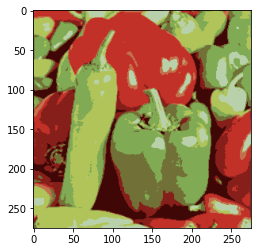

In [8]:
plt.imshow(globalBest.reconstruct())

In [9]:
clusters = globalBest.clusters
clusters.shape

(8, 3)